# Pandas Overview — Solutions

This notebook walks through the core pandas patterns that we're learning in this  course. We'll use the car listings dataset throughout so the context stays familiar.

**By the end you'll know how to:**
- Create new columns from existing ones
- Clean string columns efficiently
- Filter rows with `.loc` and `.query()`
- Aggregate data with `groupby` + `agg`

**Part 2** then shows how these pieces combine to answer three questions from Assignment 1 that people found tricky.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# On your computer, just put car_listings.csv in the same folder as this notebook
#listings = pd.read_csv('car_listings.csv')

# On my computer, it's more convenient for me *not* to make copies of everything
listings = pd.read_csv("../../2026/spring/data/car_listings.zip")

# Type conversions (same as every assignment)
listings['time_posted']           = pd.to_datetime(listings['time_posted'], errors='coerce')
listings['year_from_time_posted'] = listings['time_posted'].dt.year
listings['year']       = pd.to_numeric(listings['year'],       errors='coerce').astype('Int64')
listings['odometer']   = pd.to_numeric(listings['odometer'],   errors='coerce').astype('Int64')
listings['post_id']    = pd.to_numeric(listings['post_id'],    errors='coerce').astype('Int64')
listings['num_images'] = pd.to_numeric(listings['num_images'], errors='coerce').astype('Int64')
listings['price']      = pd.to_numeric(listings['price'],      errors='coerce')

print(listings.shape)

(333422, 25)


---
# Part 1: Building Blocks

## 1. Making New Columns

The basic pattern is `df['new_col'] = <expression>`. The expression runs on the whole column at once — no loop needed.

In [ ]:
# Arithmetic on two columns
listings['car_age'] = listings['year_from_time_posted'] - listings['year']

# Comparison → boolean column  (True/False)
listings['high_mileage'] = listings['odometer'] > 150_000

# Math on two columns — note: produces NaN where either input is missing, inf where odometer == 0
listings['price_per_mile'] = listings['price'] / listings['odometer']

# I _love_ `sample` as a way to look at data in a data frame
listings[['odometer', 'price', 'car_age', 'high_mileage', 'price_per_mile']].sample(10)

,odometer,price,car_age,high_mileage,price_per_mile
121884,70000,3000.0,22.0,False,0.042857
183940,72000,10800.0,10.0,False,0.15
313930,122000,5300.0,13.0,False,0.043443
172569,160977,8900.0,10.0,True,0.055287
295450,123123,12000.0,17.0,False,0.097464
87814,178000,3700.0,17.0,True,0.020787
208682,149000,16500.0,4.0,False,0.110738
288480,119500,4600.0,16.0,False,0.038494
76391,200000,2500.0,23.0,True,0.0125
240210,84000,14990.0,41.0,False,0.178452


### apply with a lambda

When the expression you need is more complex, `apply(lambda x: ...)` runs a custom function element-by-element. The `lambda` is just a compact, anonymous function.

In [5]:
# Cap odometer at 500,000 to remove obvious data errors, leave NaN as-is
listings['odometer_capped'] = listings['odometer'].apply(
    lambda x: min(x, 500_000) if pd.notna(x) else x
)
# The "x" is the argument that gets passed in. So if you're applying this down a column,
# you'll get each value in the column passed in as "x". 

# Equivalent without apply (faster, but less readable for complex logic):
# listings['odometer_capped'] = listings['odometer'].clip(upper=500_000)

print(f'Before cap — max odometer: {listings['odometer'].max():_}')
print(f'After cap  — max odometer: {listings['odometer_capped'].max():_}')

Before cap — max odometer: 10_000_000
After cap  — max odometer: 500_000.0


**Try it:** Create a `log_price` column using `np.log(listings['price'])`. What happens to rows where `price` is zero or negative?

In [6]:
listings['log_price'] = np.log(listings['price'])

# log(0) = -inf, log(negative) = NaN
# Check:
print(listings.loc[listings['price'] <= 0, ['price', 'log_price']].head())

       price  log_price
29457    0.0       -inf
44376    0.0       -inf
58332    0.0       -inf
59330    0.0       -inf
87209    0.0       -inf


/opt/anaconda3/lib/python3.12/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


## 2. Cleaning String Columns

String columns in this dataset can be inconsistently capitalized (`Ford`, `ford`, `FORD` all may exist). We want lowercase everywhere so grouping and comparisons work reliably.

Pandas strings have a `.str` accessor that vectorizes string methods — no loop over rows needed.

In [7]:
# Naive approach: one line per column — works but gets tedious for 10 columns
# listings['make']  = listings['make'].str.lower()
# listings['model'] = listings['model'].str.lower()
# listings['fuel']  = listings['fuel'].str.lower()
# ...

# Elegant approach: define the list once, loop once
str_cols = ['make', 'model', 'location', 'title', 'fuel',
            'drive', 'transmission', 'paint', 'type', 'condition']

for col in str_cols:
    listings[col] = listings[col].str.lower()

listings[['make', 'model', 'fuel', 'drive']].head(4)

,make,model,fuel,drive
0,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN
2,ford,expedition,gas,4wd
3,NaN,NaN,NaN,NaN


In [8]:
# While we're at it: drop duplicate post IDs
listings = listings.drop_duplicates(subset='post_id')
print(listings.shape)

(313986, 30)


## 3. Filtering with `.loc` and `.query()`

Two main tools for selecting rows that meet a condition.

In [9]:
# .loc[row_condition, columns]  — the row condition is a boolean Series
# Select specific columns at the same time
listings.loc[
    listings['price'] > 40_000,
    ['make', 'model', 'year', 'price', 'odometer']
].head(5)

,make,model,year,price,odometer
17,NaN,NaN,2022,69999.0,426000
141,ford,transit 250,2023,44999.0,680000
142,chevrolet,ss,1967,45000.0,724000
144,ford,NaN,2022,101000.0,301000
216,mercedes-benz,NaN,2020,54000.0,22786


In [11]:
# You can make code more readable by putting the columns in a list
select_cols = ['make', 'model', 'year', 'price', 'odometer']

listings.loc[listings['price']> 40_000, select_cols].head(5)

,make,model,year,price,odometer
17,NaN,NaN,2022,69999.0,426000
141,ford,transit 250,2023,44999.0,680000
142,chevrolet,ss,1967,45000.0,724000
144,ford,NaN,2022,101000.0,301000
216,mercedes-benz,NaN,2020,54000.0,22786


In [ ]:
# .query() — pass a string expression, often more readable for compound conditions
listings.query('price > 40_000 and make == "ford"').loc[:, select_cols].head(5)

# Equivalent .loc:
# listings.loc[(listings['price'] > 40_000) & (listings['make'] == 'ford'),select_cols].head(5)

,make,model,year,price,odometer
141,ford,transit 250,2023,44999.0,680000
144,ford,NaN,2022,101000.0,301000
352,ford,NaN,2019,47500.0,55500
392,ford,f350,2017,69250.0,19500
504,ford,transit 250,2023,42000.0,13800


In [13]:
# You can reference columns you created — including booleans
listings.query('high_mileage and price < 8_000')[['make', 'model', 'odometer', 'price']].head(5)

/var/folders/27/b9yz8l6s1wb47w_ljbz9ws2w0000gn/T/ipykernel_90551/1003131582.py:2: RuntimeWarning: Engine has switched to 'python' because numexpr does not support extension array dtypes. Please set your engine to python manually.
  listings.query('high_mileage and price < 8_000')[['make', 'model', 'odometer', 'price']].head(5)


,make,model,odometer,price
2,ford,expedition,190000,2000.0
10,volvo,NaN,750000,6000.0
14,chrysler,200,194000,2600.0
16,ford,f150,211000,6500.0
18,nissan,rogue,156000,3500.0


**Try it:** In the first assignment, we saw prices of up to \$200,000. Use the cell below to select a few key columns and evaluate the whether or not these prices seem legitimate. 

In [19]:
(listings
    .query('price > 180_000')
    .loc[:, ['make', 'model', 'location',
             'year', 'price', 'odometer',
             'title_text']]
    .sort_values(by="price", ascending=False)
)

,make,model,location,year,price,odometer,title_text
4363,ford,NaN,kansascity,1934,200000.0,240000,All Steel 34 Ford Coupe
9424,ford,NaN,chicago,1934,200000.0,301000,1934 Ford All Steel 3 Window
254442,tesla,cybertruck,chicago,2024,199999.0,10000,Tesla Cybertruck AWD Foundation Series
308707,dodge,charger,chicago,1970,199900.0,21226,1970 Dodge Charger R/T - Factory R-code Hemi -...
298535,dodge,charger,minneapolis,1970,199900.0,21226,1970 Dodge Charger R/T - Factory R-code Hemi -...
126502,NaN,NaN,minneapolis,2018,195000.0,152000,2018 Kenworth T880 w/ 2023 Sidedumper trailer
234357,chevrolet,NaN,chicago,1951,195000.0,25000,1951 Chevy 3600
182199,kia,sorento,minneapolis,2017,190000.0,140000,2017 Kia Sorento black
209819,dodge,challenger,minneapolis,2023,189950.0,190000,2023 dodge challenger demon170
196620,dodge,challenger,minneapolis,2023,189950.0,190000,2023 dodge challenger demon170


**Try it:** Filter to listings in `chicago` with `odometer` under 50,000. How many are there?

In [20]:
chicago_low_miles = listings.query('location == "chicago" and odometer < 50_000')
print(len(chicago_low_miles))

8010


/var/folders/27/b9yz8l6s1wb47w_ljbz9ws2w0000gn/T/ipykernel_90551/2412285881.py:1: RuntimeWarning: Engine has switched to 'python' because numexpr does not support extension array dtypes. Please set your engine to python manually.
  chicago_low_miles = listings.query('location == "chicago" and odometer < 50_000')


## 4. GroupBy and Aggregation

The split–apply–combine pattern: **split** the data into groups, **apply** a function to each group, **combine** the results into a table.

`.agg()` is the workhorse — it lets you compute multiple statistics at once and give them meaningful names.

In [21]:
# Single stat: mean price per make, sorted descending
listings.groupby('make')['price'].mean().sort_values(ascending=False).head(8)

make
lucid           78000.000000
rivian          73247.925926
ferrari         72484.615385
aston martin    67413.809524
rolls-royce     47277.777778
lamborghini     40886.250000
polestar        33931.125000
bentley         32282.439024
Name: price, dtype: float64

In [27]:
# Multiple stats at once with named aggregation
# Syntax: new_col_name = ('source_col', 'function')
(listings
    .groupby('make',as_index=False)
    .agg(
        n             = ('price', 'count'),
        median_price  = ('price', 'median'),
        mean_price    = ('price', 'mean'))
    .sort_values('mean_price', 
                 ascending=False)
    .head(8)
)

,make,n,median_price,mean_price
34,lucid,1,78000.0,78000.000000
49,rivian,27,74999.0,73247.925926
14,ferrari,13,72500.0,72484.615385
2,aston martin,21,75000.0,67413.809524
50,rolls-royce,36,30000.0,47277.777778
29,lamborghini,8,16500.0,40886.250000
45,polestar,8,27249.5,33931.125000
4,bentley,41,31900.0,32282.439024


**Try it:** Add a query statement to the above to limit to makes that have at least 50 listings. 

In [28]:
(listings
    .groupby('make',as_index=False)
    .agg(
        n             = ('price', 'count'),
        median_price  = ('price', 'median'),
        mean_price    = ('price', 'mean'))
    .sort_values('mean_price', 
                 ascending=False)
    .query('n > 50')
    .head(10)
)

,make,n,median_price,mean_price
58,tesla,709,28200.0,31872.997179
55,srt,202,24999.0,30956.574257
47,porsche,1241,19500.0,29118.135375
17,freightliner,1547,20000.0,27497.738203
44,plymouth,522,16125.0,26491.107280
35,maserati,166,20000.0,22680.493976
1,alfa romeo,91,13500.0,17296.208791
48,ram,7459,12000.0,16532.019306
30,land rover,951,9900.0,14775.360673
22,hummer,492,8975.0,13823.532520


**Try it:** Find the median `odometer` reading for each `location`. Which location has the highest median mileage?

In [29]:
(
    listings
    .groupby('location')['odometer']
    .median()
    .sort_values(ascending=False)
)

location
grandrapids    150789.0
milwaukee      147460.0
madison        145835.0
duluth         144000.0
minneapolis    143212.0
kansascity     143000.0
fargo          142400.0
appleton       141148.0
stlouis        139975.0
desmoines      132500.0
chicago        130000.0
omaha          129000.0
Name: odometer, dtype: Float64

**Try it:** Now add the count of listings to the above output. Do you notice think there are any patterns between the number of listings and the median odometer?

In [34]:
(
    listings
    .groupby('location',as_index=False)
    .agg(
        n = ('price','count'),
        med_odometer = ('odometer','median'))
    .sort_values(by="med_odometer",ascending=False)
)

,location,n,med_odometer
5,grandrapids,11621,150789.0
8,milwaukee,26588,147460.0
7,madison,13441,145835.0
3,duluth,6462,144000.0
9,minneapolis,67388,143212.0
6,kansascity,25811,143000.0
4,fargo,4952,142400.0
0,appleton,5704,141148.0
11,stlouis,23020,139975.0
2,desmoines,8781,132500.0


## 5. For Loops vs. Vectorized Operations

If you are coming to pandas from base Python, writing a `for` loop over rows feels natural. It works — but it can be dramatically slower than the pandas equivalents you have been seeing.

Under the hood, pandas delegates column operations to NumPy, which runs compiled C code on entire arrays at once. A Python `for` loop, by contrast, runs through the Python interpreter once per row, which carries significant overhead.

The comparison below uses `iterrows()`, which is the loop-friendly pandas API — and one of the most common traps students fall into.

In [37]:
import time

sample = listings.sample(100_000, random_state=20260223).copy()

# --- Loop approach using iterrows() ---
start = time.time()
result = []
for _, row in sample.iterrows():
    result.append(row['odometer'] > 150_000)
sample['hm_loop'] = result
loop_time = time.time() - start

# --- Vectorized approach ---
start = time.time()
sample['hm_vec'] = sample['odometer'] > 150_000
vec_time = time.time() - start

print(f'Loop (iterrows):  {loop_time:.3f}s')
print(f'Vectorized:       {vec_time:.6f}s')
print(f'Speedup:          ~{loop_time / vec_time:.0f}x faster')

Loop (iterrows):  1.135s
Vectorized:       0.000426s
Speedup:          ~2665x faster


On 100,000 rows the loop typically takes 1–3 seconds; the vectorized version runs in microseconds — a gap of **1,000x or more**. On the full 250k-row dataset, that difference becomes deeply painful. And remember, the full Carbitrage data set is 3.6 million rows.

**When are loops actually fine?**
- Iterating over a small number of **columns** (not rows) — you saw this in the string-cleaning loop above
- When your per-row logic genuinely cannot be expressed as a column operation (rare, and usually a sign to reach for `apply`)
- When the bottleneck is I/O or an external API call, not computation

The rule of thumb: loops over rows are almost always the wrong tool in pandas. If you find yourself writing `for _, row in df.iterrows()`, pause and ask whether there is a column-level operation that does the same thing.

---
# Part 2: Putting It Together

The three questions below are representative of what students find hardest in Assignment 1. Each one is just a combination of the patterns above.

## Q1: Which make/models have the highest proportion of high-mileage listings?

*(Restrict to make/models with at least 100 listings.)*

**Key insight:** the mean of a boolean column equals the proportion of `True` values.

In [38]:
(
    listings
    .groupby(['make', 'model'])
    .agg(
        n           = ('high_mileage', 'count'),
        pct_high    = ('high_mileage', 'mean'),   # mean of bool = proportion of True
    )
    .query('n >= 100')
    .sort_values('pct_high', ascending=False)
    .head(10)
)

/var/folders/27/b9yz8l6s1wb47w_ljbz9ws2w0000gn/T/ipykernel_90551/3417538294.py:8: RuntimeWarning: Engine has switched to 'python' because numexpr does not support extension array dtypes. Please set your engine to python manually.
  .query('n >= 100')


,,n,pct_high
make,model,,
toyota,sequoia,562,0.816726
dodge,sprinter 2500,108,0.814815
ford,excursion,280,0.810714
chevrolet,suburban 1500,165,0.806061
nissan,xterra,233,0.776824
honda,element,431,0.767981
gmc,yukon xl,255,0.760784
chevrolet,avalanche,624,0.745192
volvo,v70,109,0.743119


## Q2: Which makes have the highest median price-per-mile?

*(Restrict to makes with at least 50 listings. Exclude odometer == 0 to avoid division artifacts.)*

In [39]:
(
    listings
    .query('odometer > 0')          # avoid inf from dividing by zero
    .groupby('make')
    .agg(
        n          = ('price_per_mile', 'count'),
        median_ppm = ('price_per_mile', 'median'),
    )
    .query('n >= 50')
    .sort_values('median_ppm', ascending=False)
    .head(10)
)

/var/folders/27/b9yz8l6s1wb47w_ljbz9ws2w0000gn/T/ipykernel_90551/632416166.py:3: RuntimeWarning: Engine has switched to 'python' because numexpr does not support extension array dtypes. Please set your engine to python manually.
  .query('odometer > 0')          # avoid inf from dividing by zero
/var/folders/27/b9yz8l6s1wb47w_ljbz9ws2w0000gn/T/ipykernel_90551/632416166.py:9: RuntimeWarning: Engine has switched to 'python' because numexpr does not support extension array dtypes. Please set your engine to python manually.
  .query('n >= 50')


,n,median_ppm
make,,
tesla,708,0.643061
maserati,166,0.354074
plymouth,522,0.287341
srt,201,0.271739
porsche,1240,0.238667
alfa romeo,91,0.222039
jaguar,1003,0.092784
genesis,229,0.089316
land rover,951,0.088435


## Q3: How many listings were posted each month?

`.dt.to_period('M')` converts a datetime to a Year-Month label (e.g., `2024-09`) that's easy to group on.

In [40]:
listings['year_month'] = listings['time_posted'].dt.to_period('M')

by_month = (
    listings
    .groupby('year_month')
    .size()
    .reset_index(name='count')
)
by_month

/var/folders/27/b9yz8l6s1wb47w_ljbz9ws2w0000gn/T/ipykernel_90551/2362108217.py:1: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  listings['year_month'] = listings['time_posted'].dt.to_period('M')


,year_month,count
0,2023-05,64
1,2023-06,344
2,2023-07,10901
3,2023-08,10389
4,2023-09,10536
5,2023-10,10570
6,2023-11,9024
7,2023-12,5181
8,2024-01,6206
9,2024-02,7817


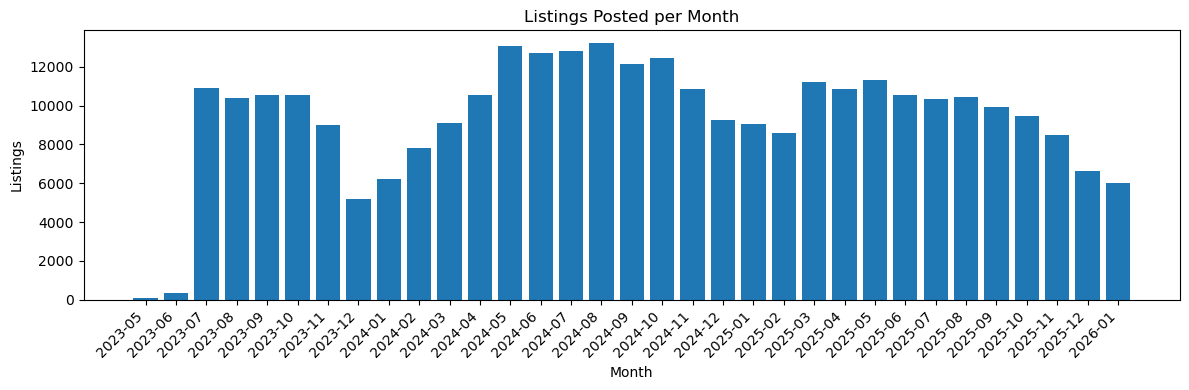

In [41]:
fig, ax = plt.subplots(figsize=(12, 4))
ax.bar(by_month['year_month'].astype(str), by_month['count'])
ax.set_xlabel('Month')
ax.set_ylabel('Listings')
ax.set_title('Listings Posted per Month')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()